# Set up

Python librairies imports :

In [106]:
# File system management
import os
from pathlib import Path
import io

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image manipulation
from PIL import Image

# Dimension reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Tensorflow
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# Pyspark
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

%matplotlib inline
sns.set_theme(palette="Set2")

Define work location :

In [102]:
# Current project path
PATH_PROJ = '/Users/victor/Documents/OPENCLASSROOMS/projet_8'

# Define images paths
PATH_DATA = PATH_PROJ + '/data/test'
PATH_RESULTS = PATH_PROJ + '/data/results'

# Change directory
os.chdir(PATH_PROJ)

Create the **Spark** session :

In [17]:
# Create sparkSession
spark = (SparkSession
         .builder
         .appName('oc_p8')
         .master('local')
         .config("spark.sql.parquet.writeLegacyFormat", 'true')
         .getOrCreate())

# Create sparkContext
sc = spark.sparkContext

spark

# Data exploration

In [103]:
# Count images
img_count = len([f for f in Path(PATH_DATA).rglob('*.jpg') if f.is_file()])
print("Number of JPG files in " + PATH_DATA + " : " + str(img_count))

Number of JPG files in /Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training : 6231


In [104]:
# Create list of images
images_list = [(file_name, dir_path.split('/')[-1]) for (dir_path, _, file_names) in os.walk(PATH_DATA) \
               for file_name in file_names if file_name.endswith('.jpg')]

# Create dataframe
images_df = pd.DataFrame(images_list, columns=['image', 'label'])

# Add categories
images_df['category'] = images_df['label'].apply(lambda x: x.split('_')[0]) 
display(images_df.head())

,image,label,category
0,r0_190.jpg,cucumber_3,cucumber
1,r0_184.jpg,cucumber_3,cucumber
2,r0_52.jpg,cucumber_3,cucumber
3,r0_46.jpg,cucumber_3,cucumber
4,r0_8.jpg,cucumber_3,cucumber


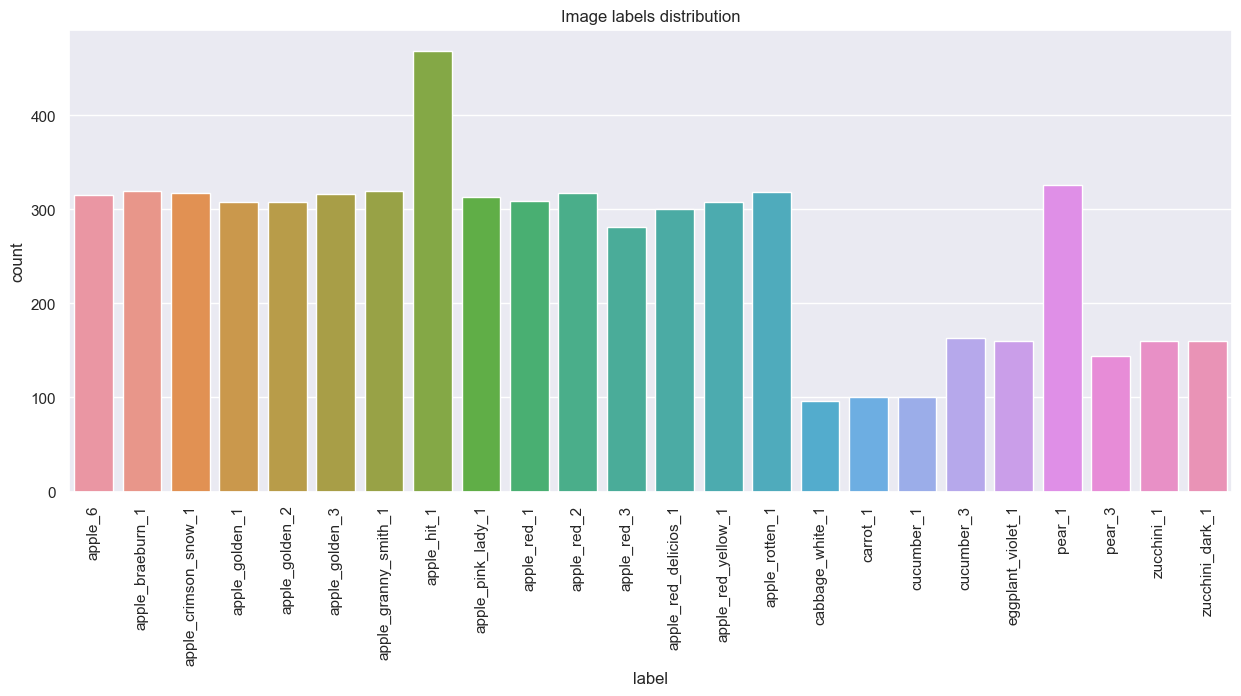

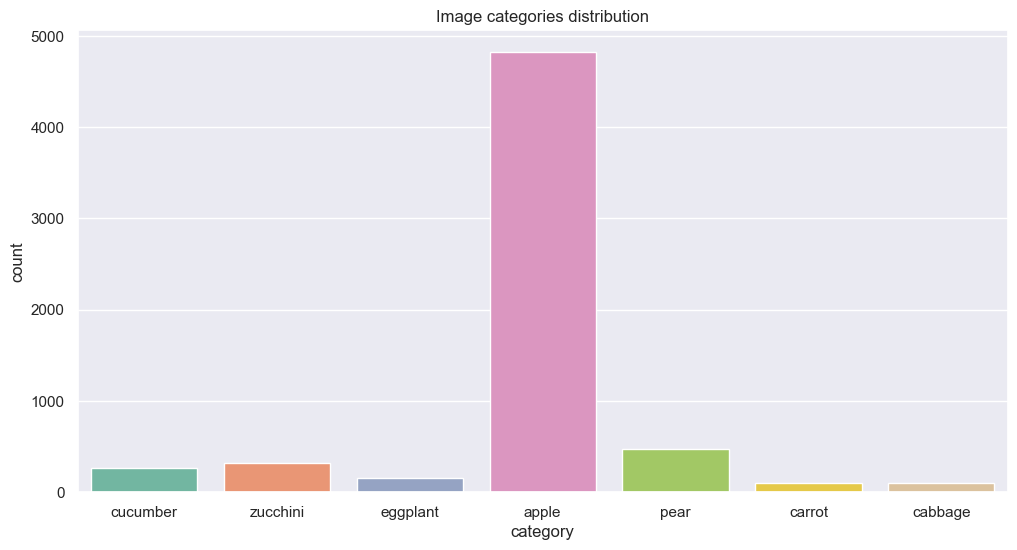

In [105]:
# Display image labels
plt.figure(figsize=(15, 6))
plt.title("Image labels distribution")
sns.countplot(x=images_df['label'].sort_values())
plt.xticks(rotation=90)
plt.show()

# Display image categories
plt.figure(figsize=(12, 6))
plt.title("Image categories distribution")
sns.countplot(x=images_df['category'])
# plt.xticks(rotation=90)
plt.show()

# Data processing

### Load images

In [19]:
# Load all images
images = spark.read.format("binaryFile").option("pathGlobFilter", "*.jpg").option("recursiveFileLookup", "true").load(PATH_DATA)

In [20]:
# Display first images
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+-------------------------------------------------------------------------------------+-----------+
|path                                                                                 |label      |
+-------------------------------------------------------------------------------------+-----------+
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/test/apple_hit_1/r0_115.jpg|apple_hit_1|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/test/apple_hit_1/r0_119.jpg|apple_hit_1|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/test/apple_hit_1/r0_107.jpg|apple_hit_1|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/test/apple_hit_1/r0_143.jpg|apple_hit_1|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/test/apple_hit_1/r0_111.jpg|app

### MobileNetV2 model

* Create a MobileNetV2 model with top layer removed and broadcasted pretrained weights.

In [21]:
# Load default model
mn_default = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Create model without top layer
mn_custom = Model(inputs=mn_default.input, outputs=mn_default.layers[-2].output)
display(mn_custom.summary())

# Create broadcast weights 
brodcast_weights = sc.broadcast(mn_custom.get_weights())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

None

In [22]:
def model_fn():
    """ Returns a MobileNetV2 model with top layer removed 
        and broadcasted pretrained weights.

    Returns:
        MobileNetV2 model
    """
    # Load default model
    mn = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

    # Customize layers
    for layer in mn.layers:
        layer.trainable = False
    
    # Create model without top layer
    model = Model(inputs=mn.input, outputs=mn.layers[-2].output)

    # Broadcast weights to workers
    model.set_weights(brodcast_weights.value)

    return model

### Images features

* Peprocess and featurize the images with a MobileNetV2 model.

In [23]:
def preprocess(content):
    """Preprocesses raw image bytes.

    Args:
        content: PIL Image

    Returns:
        Numpy array
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

In [24]:
def featurize_series(model, content_series):
    """Featurize a pd.Series of raw images using the input model.

    Args:
        model: CNN model
        content_series: pd.Series of image data

    Returns:
        pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [25]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    """ This method is a Scalar Iterator pandas UDF wrapping our featurization function.
        The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    Args:
        content_series_iter: Iterator over batches of data, where each batch
                             is a pandas Series of image data.

    Yields:
        pd.Series of image features
    """
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/Users/victor/miniconda3/envs/oc_p7/lib/python3.10/site-packages/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [67]:
# Select 10% of dataset
images_sample = images.sample(fraction=0.1, seed=42)

In [68]:
# Create the image features
features_df = images_sample.repartition(20).select(col("path"), col("label"),
                                                   featurize_udf("content").alias("features"))
display(features_df)

# Save results as parquet files
features_df.write.mode("overwrite").parquet(PATH_RESULTS)

DataFrame[path: string, label: string, features: array<float>]

2023-03-03 10:31:00.635114: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


# Results

In [69]:
# Load results as a dataframe
res_df = pd.read_parquet(PATH_RESULTS, engine='pyarrow')

display(res_df.head())

,path,label,features
0,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,apple_red_delicios_1,"[0.06056703, 0.0, 0.0, 0.0, 0.0, 1.4813036, 0...."
1,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,cucumber_3,"[1.1408564, 0.4854249, 0.17747277, 0.39273074,..."
2,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,cucumber_3,"[0.88065255, 0.6794807, 0.17219357, 0.0, 0.326..."
3,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,apple_braeburn_1,"[0.12946434, 7.051351e-05, 0.023543494, 0.0, 0..."
4,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,pear_1,"[1.9898766, 0.39016345, 0.02785417, 0.0, 0.0, ..."


### TSNE

In [70]:
# Extract features
features_df = pd.DataFrame(res_df['features'].values.tolist(), index=res_df.index)

# Create t-sne dataframe
tsne_df = pd.DataFrame(TSNE().fit_transform(features_df), columns=['TSNE1', 'TSNE2'])

# Add label
tsne_df['label'] = res_df['label']

display(tsne_df.head())

,TSNE1,TSNE2,label
0,-7.610940,2.061130,apple_red_delicios_1
1,15.953443,-2.795345,cucumber_3
2,15.434394,-2.514667,cucumber_3
3,-10.031773,1.667457,apple_braeburn_1
4,-4.745637,-17.738123,pear_1


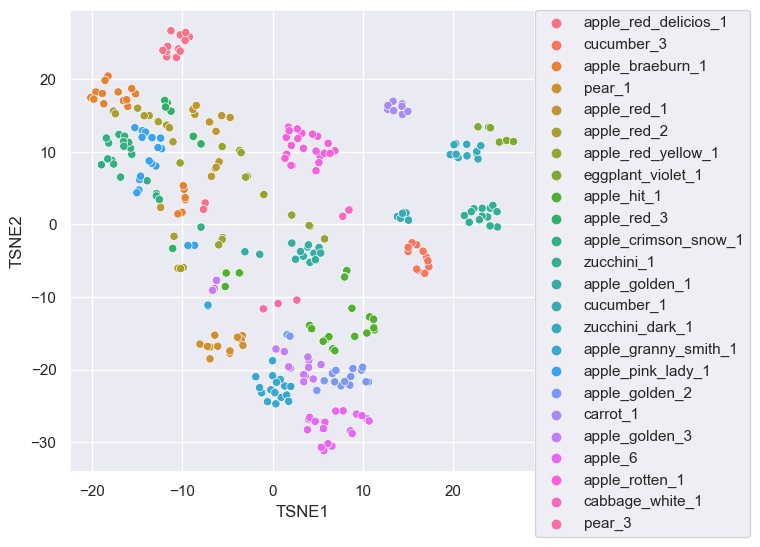

In [71]:
# Display scatterplot
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='label')
plt.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.)
plt.show()

### PCA

In [130]:
# Create PCA model
pca = PCA(n_components=100)

# Fit to data 
pca_data = pca.fit_transform(features_df)
pca_df = pd.DataFrame(pca_data, columns=['PCA'+str(i) for i in range(1, pca_data.shape[1]+1)])
display(pca_df.head())


,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA91,PCA92,PCA93,PCA94,PCA95,PCA96,PCA97,PCA98,PCA99,PCA100
0,3.894730,3.804193,2.652119,-6.464392,-0.253866,-2.831323,3.074295,-0.006018,2.502177,2.657274,...,-0.683758,0.314567,0.846811,0.096903,0.810770,-0.168164,-0.639290,-0.587515,0.115616,-0.542691
1,-7.700239,4.751587,-1.467708,6.962124,-8.146514,-1.349648,-3.669908,-2.696400,5.536300,2.867600,...,-0.170689,-0.411741,-0.413486,-0.085987,0.245765,-0.324085,0.178481,-0.587108,-0.216275,0.269401
2,-6.771380,4.801210,-1.983373,6.173006,-6.656211,-0.239476,-2.245909,-3.680728,5.333299,3.029959,...,-0.919459,-1.587396,-0.151753,-0.431163,0.455890,0.007726,-1.418752,0.373106,-0.505175,-0.663340
3,3.217381,2.583936,6.183118,-9.430029,-0.204082,-1.878263,0.762738,0.210456,1.700877,3.970676,...,0.150190,0.058280,-1.111931,-0.394798,0.349223,1.105173,-0.051774,-0.755103,0.021670,0.439272
4,-0.739983,-6.293474,0.891964,0.463593,-3.218066,6.821277,-5.005847,0.346199,-4.121324,8.450239,...,0.351372,0.200338,-0.334468,0.195023,0.986770,0.619579,0.363609,0.159097,0.080733,-0.532981


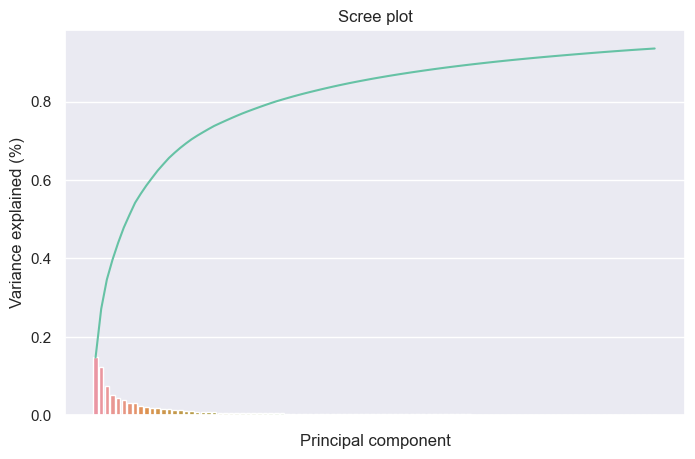

In [187]:
# Get explained variance ratio
pca_evr = list(pca.explained_variance_ratio_)
pca_evr_cumsum = np.cumsum(pca_evr)

# Display 
plt.figure(figsize=(8, 5))
plt.title("Scree plot")
sns.barplot(x=pca_df.columns, y=pca_evr)
sns.lineplot(x=pca_df.columns, y=pca_evr_cumsum)
plt.xlabel('Principal component')
plt.xticks('')
plt.ylabel('Variance explained (%)')
plt.show()

In [198]:
pca_evr_cumsum

array([0.14734839, 0.27144074, 0.34614933, 0.39670312, 0.43999532,
       0.47883117, 0.51107657, 0.5421486 , 0.56508076, 0.5862704 ,
       0.6055076 , 0.62426764, 0.6406133 , 0.65653884, 0.66984195,
       0.6822467 , 0.6935612 , 0.7041381 , 0.7133778 , 0.72190905,
       0.73023266, 0.7382038 , 0.7449024 , 0.7514699 , 0.7578704 ,
       0.76411074, 0.7701141 , 0.77566403, 0.78100544, 0.78624296,
       0.79135317, 0.7962787 , 0.8009926 , 0.8052792 , 0.8094431 ,
       0.81355613, 0.81746995, 0.82124096, 0.82483745, 0.8283438 ,
       0.8318039 , 0.8351563 , 0.83842635, 0.841615  , 0.8446477 ,
       0.8476419 , 0.85048497, 0.8532526 , 0.8559519 , 0.85860777,
       0.8611442 , 0.8636129 , 0.8660648 , 0.8683967 , 0.8706744 ,
       0.872886  , 0.8750784 , 0.87718433, 0.879272  , 0.88131213,
       0.8833076 , 0.88524246, 0.88713783, 0.8889795 , 0.89077646,
       0.89254713, 0.8942763 , 0.8959446 , 0.8975807 , 0.8991927 ,
       0.90078086, 0.90234387, 0.9038628 , 0.9053457 , 0.90680

In [201]:
# Find thresholds
for th_val in [0.8, 0.85, 0.90, 0.95, 100]:
    th_idx = np.argmax(pca_evr_cumsum > th_val)
    if th_idx > 0:
        print('{:.0%} of the variance is explained by {} principal components ({:.4})' \
              .format(th_val, th_idx+1, pca_evr_cumsum[th_idx]))

80% of the variance is explained by 33 principal components (0.801)
85% of the variance is explained by 47 principal components (0.8505)
90% of the variance is explained by 71 principal components (0.9008)
